# Interpolate 5D beam density

$x_3$ = x position at VS34 \
$y_3$ = y position at VS34 \
$x_2$ = position of VT06 slit \
$y_1$ = position of HZ04 slit \
$x_1$ = position of VT04 slit

$$
\begin{aligned}
x &= x_1 \\
y &= y_1 \\
x' &= \frac{x_2 - 0.35 x_1}{s_2 - s_1} \\
y' &= \frac{y_3 - y_1}{s_3 - s_1} \\
w  &= f(x_3, x_2, x_1) \\ 
\end{aligned}
$$

In [1]:
import sys
import os
from os.path import join
import time
from datetime import datetime
import importlib
import numpy as np
import pandas as pd
import h5py
import imageio
from scipy import ndimage
from scipy import interpolate
import skimage
from tqdm import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
from matplotlib import colors
import plotly.graph_objs as go
from ipywidgets import interact
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils
from tools.utils import project

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'

## Load 5D array 

In [3]:
folder = './_saved/2022-04-29_ruisard/'
filenames = os.listdir(folder)
for filename in filenames:
    if filename.startswith('rawgrid'):
        print(filename)
    if filename.startswith('slit_coordinates'):
        print(filename)

rawgrid_220429190854-scan-xxpy-image-ypdE.mmp
slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy
rawgrid_shape.txt


In [4]:
filename = 'rawgrid_220429190854-scan-xxpy-image-ypdE.mmp'
coordfilename = 'slit_coordinates_220429190854-scan-xxpy-image-ypdE.npy'

In [5]:
shape = tuple(np.loadtxt(join(folder, 'rawgrid_shape.txt')).astype(int))
print(shape)

(33, 33, 32, 147, 194)


In [6]:
file = open(join(folder, 'im_dtype.txt'), 'r')
dtype = file.readline()
file.close()
print(dtype)

float64


In [7]:
a5d = np.memmap(join(folder, filename), shape=shape, dtype=dtype, mode='r')
print(np.info(a5d))

class:  memmap
shape:  (33, 33, 32, 147, 194)
strides:  (240920064, 7300608, 228144, 1552, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fbee486b000
byteorder:  little
byteswap:  False
type: float64
None


Flip the y3 axis (the image comes in upside-down). Also, the y1 slit coordinates are reverse of the the y vector. (*Why flip the horizontal image?*)

In [8]:
a5d = a5d[:, :, ::-1,::-1,::-1]

## View 5D array in slit-screen coordinates

### Projections 

In [9]:
dims = ['x1', 'x2', 'y1', 'y3', 'x3']
frac_thresh = 1e-5
# frac_thresh = None

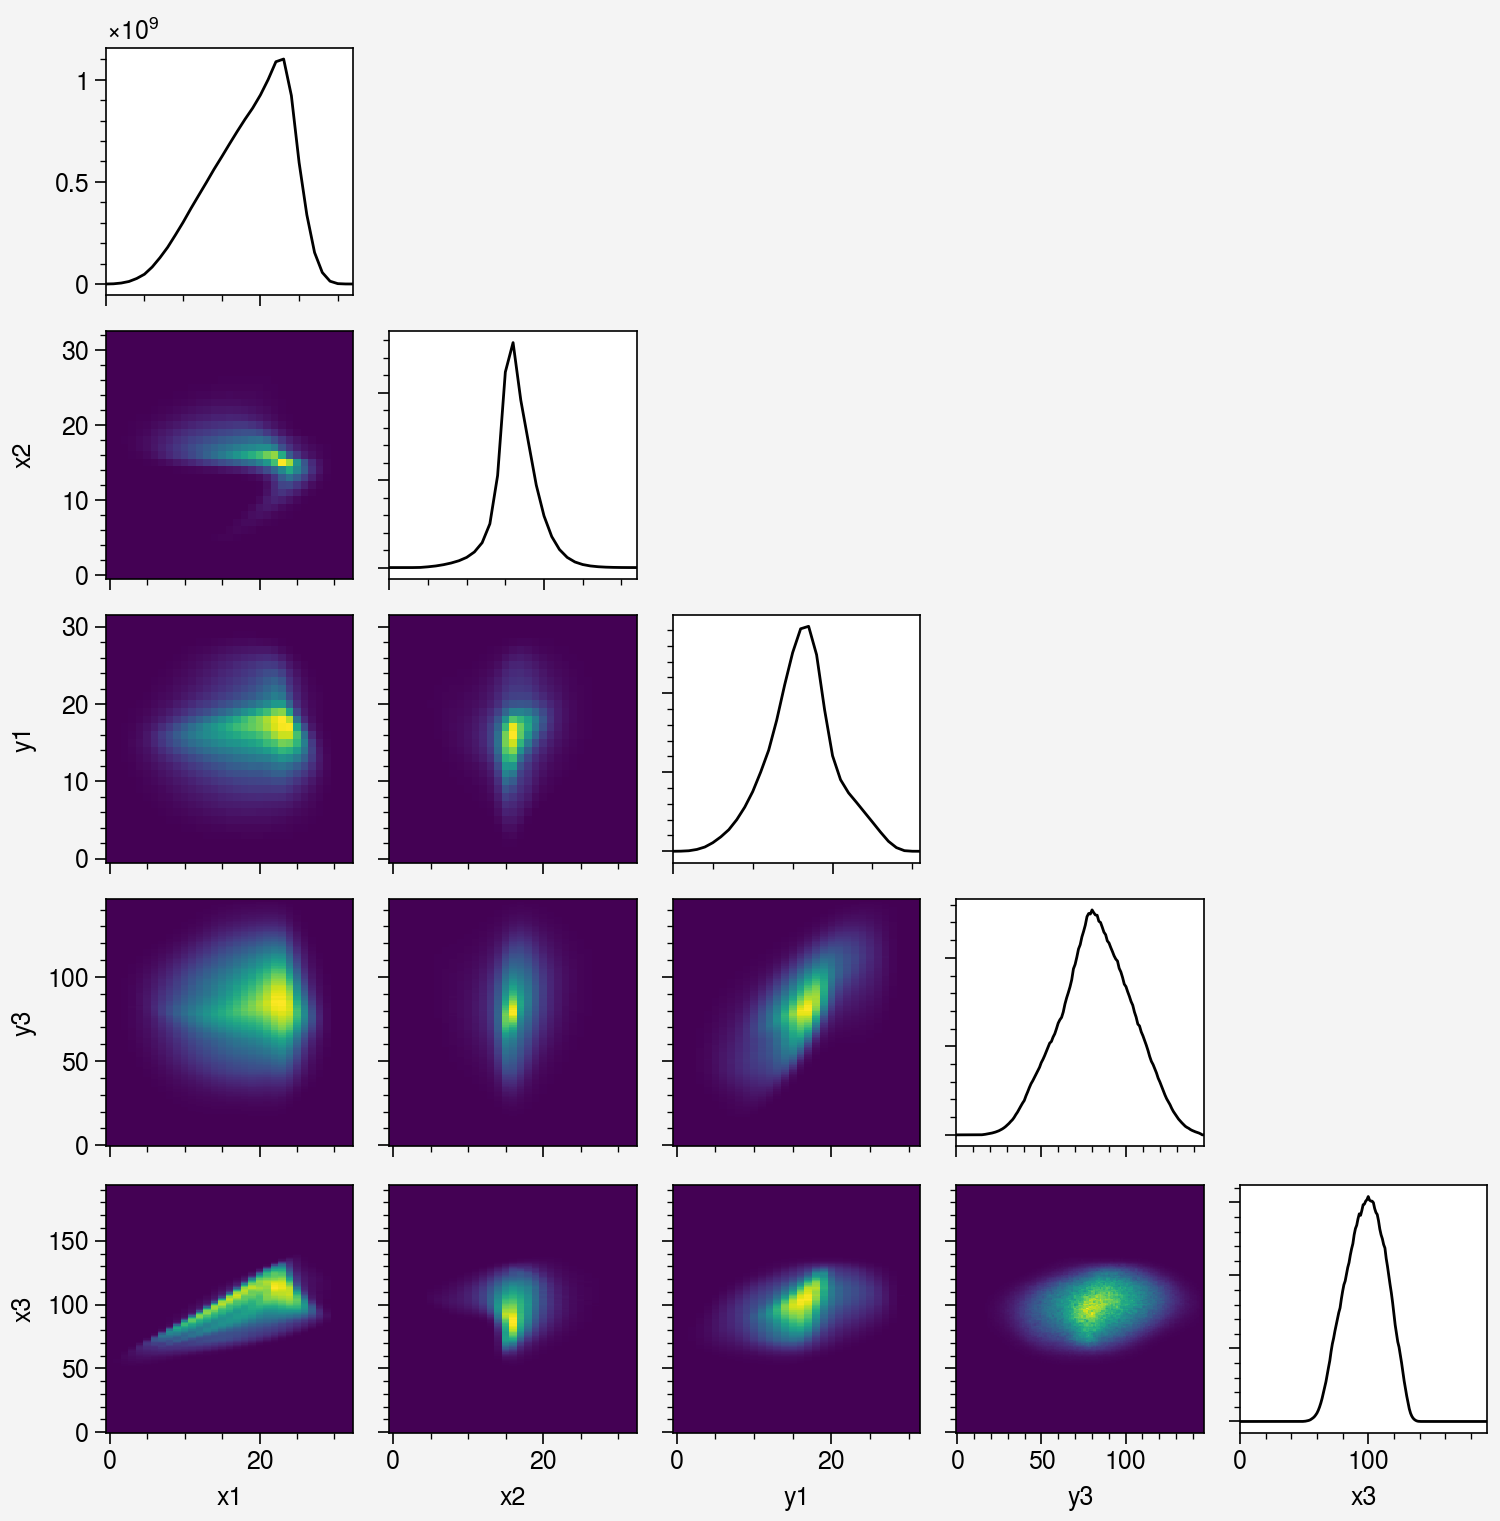

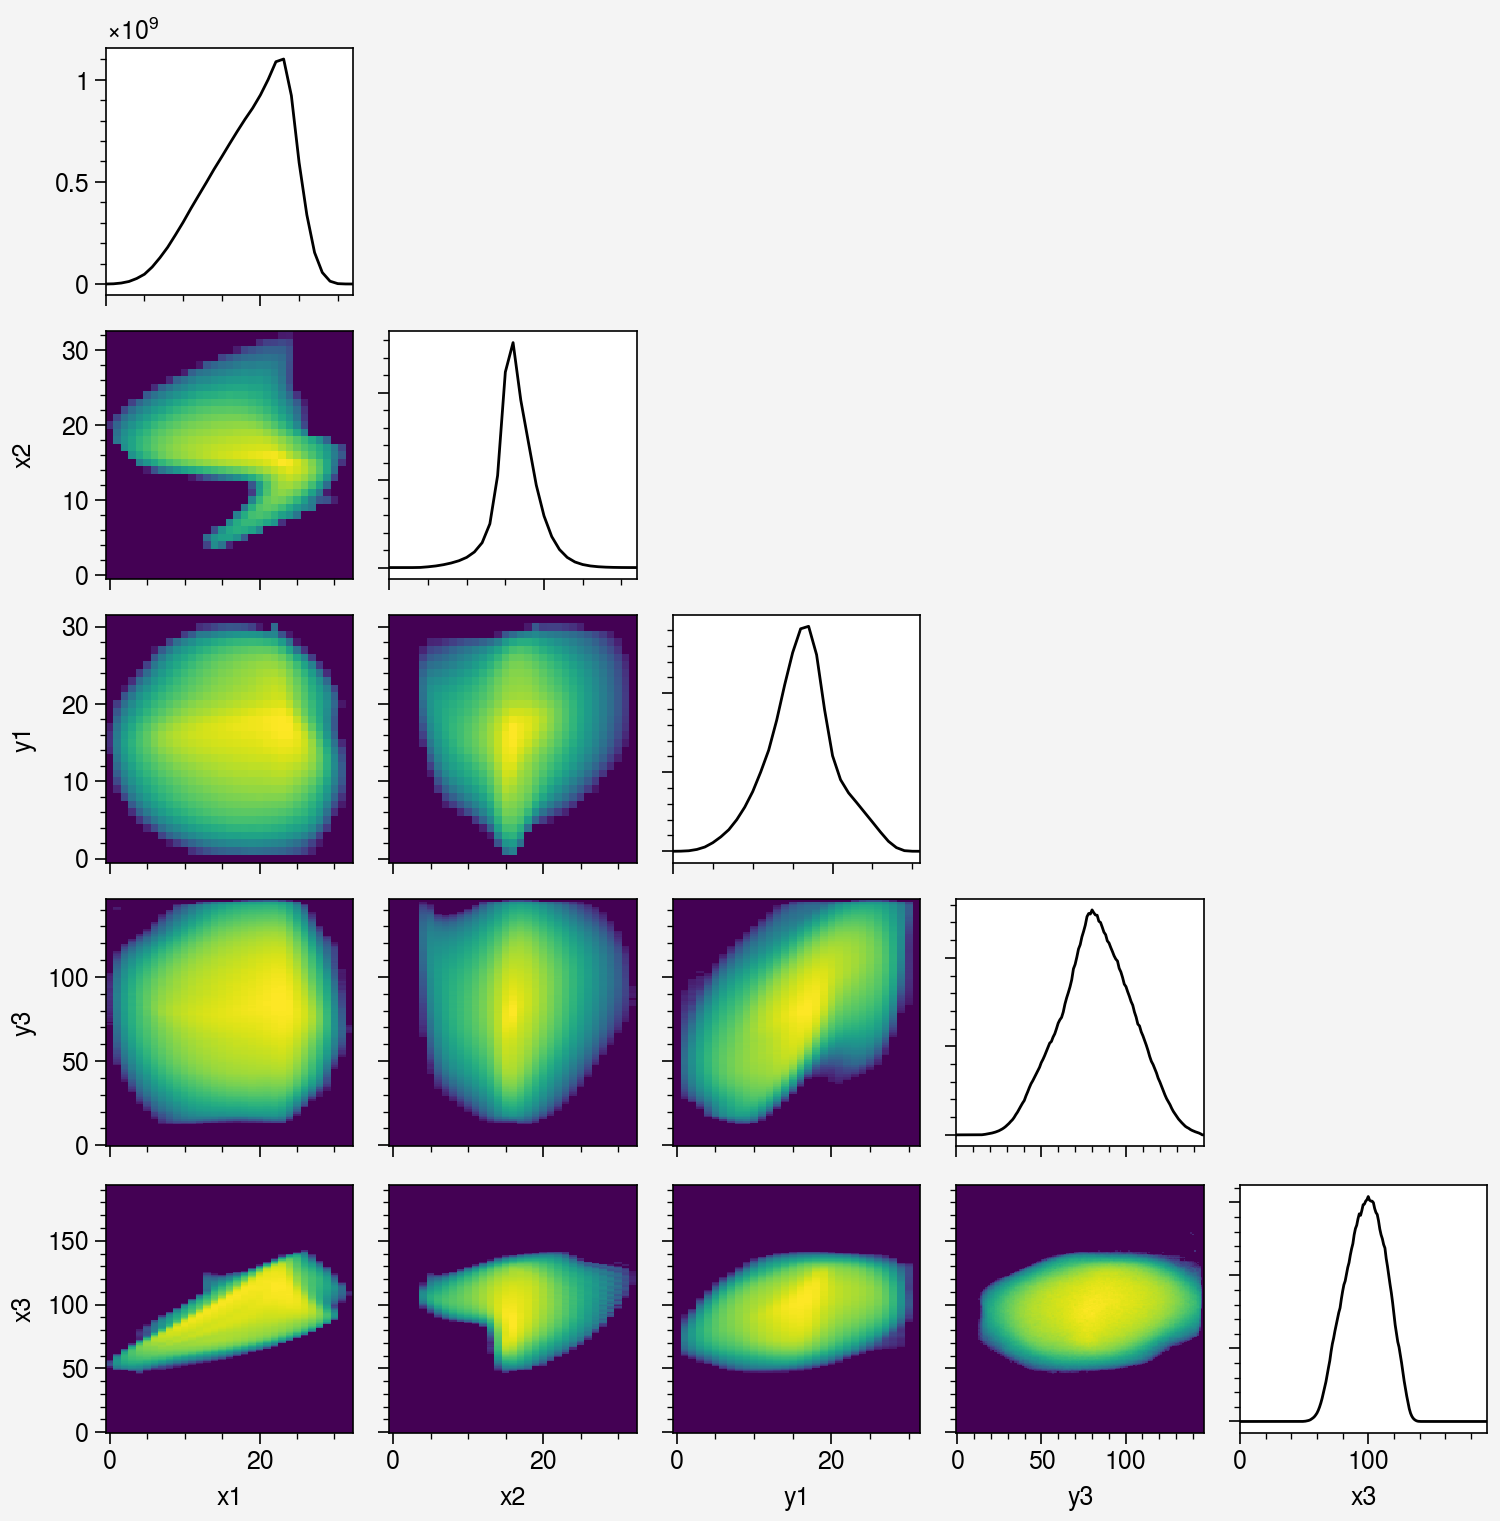

In [10]:
for norm in [None, 'log']:
    axes = mplt.corner(
        a5d,
        labels=dims,
        norm=norm,
        fig_kws=dict(figwidth=7.5),
        diag_kws=dict(lw=1.0),
        discrete=False,
        frac_thresh=frac_thresh,
    )
    plt.savefig(f"_output/corner_log{norm == 'log'}.png")
    plt.show()

### Slices

In [ ]:
dim_to_int = {dim: i for i, dim in enumerate(dims)}
int_to_dim = {i: dim for i, dim in enumerate(dims)}
cmaps = ['viridis', 'dusk_r', 'mono_r', 'grays', 'plasma', 'blues_r', 'rocket', 
         'mako', 'stellar_r',]

In [ ]:
ind = np.unravel_index(np.argmax(a5d), a5d.shape)
ind = tuple([i for i in ind])
print(ind)

In [ ]:
axes_slice = [(k, j, i) for i in range(a5d.ndim) for j in range(i) for k in range(j)]
for axes in axes_slice:
    axes_not_slice = [axis for axis in range(a5d.ndim) if axis not in axes]
    a5d_slice = utils.slice_array(a5d, axes, [ind[axis] for axis in axes])
    a5d_slice = a5d_slice / np.max(a5d_slice)
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(a5d_slice, ax=ax, frac_thresh=frac_thresh, norm=norm, colorbar=True)
    dim1, dim2 = [dims[axis] for axis in axes_not_slice]
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    # Save the figure.
    string = '_output/slice_'
    for axis in axes:
        string += f'_{int_to_dim[axis]}-{ind[axis]}'
    plt.savefig(string + '.png')
    plt.show()

## Corner without diagonal 

In [ ]:
for norm in [None, 'log']:
axes = mplt.corner_no_diag(
    a5d,
    labels=dims,
    # fig_kws=dict(figwidth=7.5),
    frac_thresh=frac_thresh,
    ec='None',
)
plt.savefig(f"_output/corner_log{norm == 'log'}.png")
plt.show()

In [ ]:
def update_projection(a5d, dim1='y3', dim2='x3', cfix=False, log=False, reverse=False, **plot_kws):
    if dim1 == dim2:
        raise ValueError('dim1 == dim2')
    dims = [dim1, dim2]
    norm = 'log' if log else None
    plot_kws['cmap'] = pplt.Colormap(plot_kws.pop('cmap'), reverse=reverse)
    image = project(a5d, axis=[dim_to_int[dim] for dim in dims])
    image = image / image.max()
    fig, ax = pplt.subplots()
    mplt.plot_image(image, ax=ax, prof=True, prof_kws=dict(scale=0.15), 
                    colorbar=True, norm=norm, **plot_kws)
    ax.format(xlabel=dim1, ylabel=dim2)
    plt.show()

In [ ]:
fig = go.FigureWidget()
heatmap = fig.add_heatmap()

@interact(dim1=dims, dim2=dims, cmap=cmaps, reverse=False, log=False, discrete=False)
def update(dim1='y3', dim2='x3', cmap='viridis', reverse=False, log=False, discrete=False):
    with fig.batch_update():
        heatmap.data = update_projection(
            a5d, dim1=dim1, dim2=dim2, log=log, discrete=discrete,
            cmap=cmap, frac_thresh=frac_thresh, reverse=reverse,
        )

In [ ]:
def update_projection_corner(
    a5d, cfix=False, log=False, reverse=False, frac_thresh=frac_thresh, 
    **plot_kws
):
    norm = 'log' if log else None
    plot_kws['cmap'] = pplt.Colormap(plot_kws.pop('cmap'), reverse=reverse)
    image = project(a5d, axis=[dim_to_int[dim] for dim in dims])
    image = image / image.max()
    axes = mplt.corner(
        a5d,
        labels=dims,
        norm=norm,
        fig_kws=dict(figwidth=7.5),
        diag_kws=dict(lw=1.0),
        frac_thresh=frac_thresh,
        **plot_kws,
    )
    plt.show()

In [ ]:
fig = go.FigureWidget()
heatmap = fig.add_heatmap()

@interact(cmap=cmaps, reverse=False, log=False, discrete=False)
def update(cmap='viridis', reverse=False, log=False, discrete=False):
    with fig.batch_update():
        heatmap.data = update_projection_corner(
            a5d, log=log, discrete=discrete,
            cmap=cmap, frac_thresh=frac_thresh, reverse=reverse,
        )

## Coordinate transform

In [ ]:
coord_3d = np.load(coordfilename)  # [X1, X2, Y1]
coord_3d.shape

In [ ]:
X

In [ ]:
x1_grid = coord_3d[0, :, 0, 0]
x2_grid = coord_3d[1, 0, :, 0]
y1_grid = coord_3d[2, 0, 0, :] 

pix2mm = -0.0659  # CHANGE THIS!!!???
y3_grid = pix2mm * np.arange(a5d.shape[3])
x3_grid = pix2mm * np.arange(a5d.shape[4])

# Flip y3 axis (image comes in upside-down)
y3_grid = y3_grid[::-1]
a5d = a5d[:, :, :, ::-1]

Y1, Y3 = np.meshgrid(y1_grid, y3_grid, indexing='ij')
_, X3 = np.meshgrid(y1_grid, x3_grid, indexing='ij')
X1 = coord_3d[0, :, :, 0]
X2 = coord_3d[1, :, :, 0]

# Make list, center coordinates. `coords_` has coordinates in raw slit values.
coords_ = [X1, X2, Y1, Y3, X3]
for coord in coords_:
    coord -= np.mean(coord)

In [ ]:
# Matrix parameters
a2mm = 1.009  # assume same as first dipole
amp2meter = a2mm * 1e3
rho = 0.3556
GL05 = 0
GL06 = 0.0
l1 = 0
l2 = 0
l3 = 0.774
L2 = 0.311  # slit2 to dipole face
l = 0.129  # dipole face to VS06 screen (assume same for 1st and last dipole/screen)
LL = l1 + l2 + l3 + L2  # distance from emittance plane to dipole entrance

ecalc = energy.EnergyCalculate(l1=l1, l2=l2, l3=l3, L2=L2, l=l, amp2meter=amp2meter)

Mslit = ecalc.getM1()  # slit-slit
Mscreen = ecalc.getM()  # slit-screen

# Matrix mupltiply to get x' and y'. The negative signs are due to the direction
# of the y-slit being opposite of the beam-frame y dimension. The screen axis is 
# also backwards, but this has been accounted for in the previous cell.
Y = Y1.copy()
YP = ecalc.calculate_yp(Y.ravel() * 1e-3, Y3.ravel() * 1e-3, Mscreen)
YP = YP.reshape(Y.shape) * 1e3

X = X1.copy()
XP = ecalc.calculate_xp(X.ravel()*1e-3,X2.ravel()*1e-3,Mslit)
W = ecalc.calculate_dE_screen(X3.ravel() * 1e-3, 0, X.ravel() * 1e-3, XP, Mscreen)
XP = XP.reshape(X.shape) * 1e3
W = W.reshape(X.shape) * 1e3

# Make list, center coordinates. `coords` has coordinates in mm, mrad. (Does it 
# really? You multiplied by 1e3.)
coords = [X, XP, Y, YP, W]
for coord in coords:
    coord -= coord.mean()
    
coord_grids = [y1grid, y3grid, x3grid]
for coord in coord_grids:
    coord -= coord.mean()

# First interpolate into regular grid in W
We are already on regular grid for y,yp

In [ ]:
nptsw = int(a5d_shape[-1])

wgv_new = np.linspace(-130,130,nptsw)

tmpfilename = filename.replace('rawgrid','step3-interpW')
a5dw_shape = tuple(np.append(a5d_shape[0:-1],nptsw))
a5d_w = np.memmap(filedir+tmpfilename,shape=a5dw_shape,dtype=np.uint32,mode='w+')

print(a5dw_shape)

# plt.figure(figsize=[9,9])
# plt.pcolor(X1[:,15,:],W[:,15,:],np.log10(a5d[:,15,15,120,:]))
# plt.xlabel('x1')
# plt.ylabel('w')

# plt.grid(axis='y')
# plt.yticks(list(wgv_new));





#### Save phase space coordinates file

In [ ]:
coord_dict = {}
dims = ['x','xp','y','yp']
for i in range(len(dims)):
    coord_dict[dims[i]] = coords[i].tolist() 
    
coord_dict['w'] = wgv_new.tolist()   

savefilename = coordfilename.replace('slit_','ps_')+'.json'
# np.save(savefilename, coord_dict)

import json
with open(savefilename, 'w') as fp:
    json.dump(coord_dict, fp)


#### Loop through x,x' and interpolate onto regular w grid

In [ ]:
len(y1grid)


In [ ]:
Ynew,YPnew,Wnew = np.meshgrid(Y1[:,0],Y3[0,:],wgv_new,indexing='ij')
newpoints = np.vstack([Ynew.flatten(),YPnew.flatten(),Wnew.flatten()]).T
np.shape(newpoints)

for i in range(np.shape(X)[0]):
    print(i)
    for j in range(np.shape(XP)[1]):
        W = ecalc.calculate_dE_screen(x3grid*1e-3, 0, X[i,j]*1e-3, XP[i,j]*1e-3, Mscreen)*1e3

        #dens3d = griddata(points,a5d_small[:,:,i,j,:].flatten(),newpoints,fill_value=0.)
        dens3d = interpn((y1grid,y3grid,W),a5d[i,j,:,:,:],newpoints,bounds_error=False,fill_value = 0.)
        a5d_w[i,j,:,:,:] = np.reshape(dens3d,np.shape(Wnew))

In [ ]:
# close a5d
del a5d
del a5d_w